# Loading the dataset

In [1]:
IMAGES_PATH = "/kaggle/input/images-data"
AUDIOS_PATH = "/kaggle/input/augmented-data/Aug_Audio/Aug_Audio"
TEXT_PATH = "/kaggle/input/augmented-data/Augmented_data/Augmented_data"

In [2]:
import librosa
import os
durations = []
for root, _, files in os.walk("/kaggle/input/augmented-data/Aug_Audio/Aug_Audio"):
    for file in files:
        if file.endswith(".wav") or file.endswith(".mp3"):
            y, sr = librosa.load(os.path.join(root, file), sr=None)
            durations.append(len(y) / sr)

print(f"Max duration: {max(durations):.2f} seconds")
print(f"Min duration: {min(durations):.2f} seconds")
print(f"Mean duration: {sum(durations) / len(durations):.2f} seconds")

Max duration: 4.10 seconds
Min duration: 1.50 seconds
Mean duration: 2.63 seconds


# Check the dataset structure

In [2]:
import os


# Function to count occurrences of each emotion
def count_files_in_folders(base_path):
    emotion_counts = {}
    for emotion in os.listdir(base_path):  # Get emotion folder names
        emotion_folder = os.path.join(base_path, emotion)
        if os.path.isdir(emotion_folder):  # Ensure it's a folder
            emotion_counts[emotion] = len(os.listdir(emotion_folder))  # Count files
    return emotion_counts

# Count emotion samples in each dataset
image_counts = count_files_in_folders(IMAGES_PATH)
audio_counts = count_files_in_folders(AUDIOS_PATH)
text_counts = count_files_in_folders(TEXT_PATH)

# Print class distributions
print("📸 Image Dataset Emotion Counts:", image_counts)
print("\n🎙️ Audio Dataset Emotion Counts:", audio_counts)
print("\n📝 Text Dataset Emotion Counts:", text_counts)

# Find unique emotions in each modality
image_classes = set(image_counts.keys())
audio_classes = set(audio_counts.keys())
text_classes = set(text_counts.keys())

# Identify inconsistencies
missing_in_images = (audio_classes | text_classes) - image_classes
missing_in_audios = (image_classes | text_classes) - audio_classes
missing_in_texts = (image_classes | audio_classes) - text_classes

# Print summary of inconsistencies
print("\n🚨 Missing Emotion Classes:")
print(f"- Missing in Images: {missing_in_images}" if missing_in_images else "- ✅ All text/audio emotions found in images")
print(f"- Missing in Audios: {missing_in_audios}" if missing_in_audios else "- ✅ All text/image emotions found in audios")
print(f"- Missing in Texts: {missing_in_texts}" if missing_in_texts else "- ✅ All image/audio emotions found in texts")


📸 Image Dataset Emotion Counts: {'surprise': 1851, 'fear': 1839, 'neutral': 1880, 'sad': 1821, 'disgust': 1740, 'happy': 1862, 'anger': 1822}

🎙️ Audio Dataset Emotion Counts: {'surprise': 1269, 'fear': 1921, 'neutral': 1795, 'sad': 1960, 'disgust': 1863, 'happy': 1853, 'anger': 1936}

📝 Text Dataset Emotion Counts: {'surprise': 1485, 'fear': 1648, 'neutral': 2899, 'sad': 1695, 'disgust': 1722, 'happy': 1813, 'anger': 1786}

🚨 Missing Emotion Classes:
- ✅ All text/audio emotions found in images
- ✅ All text/image emotions found in audios
- ✅ All image/audio emotions found in texts


# Bar plot for emotions

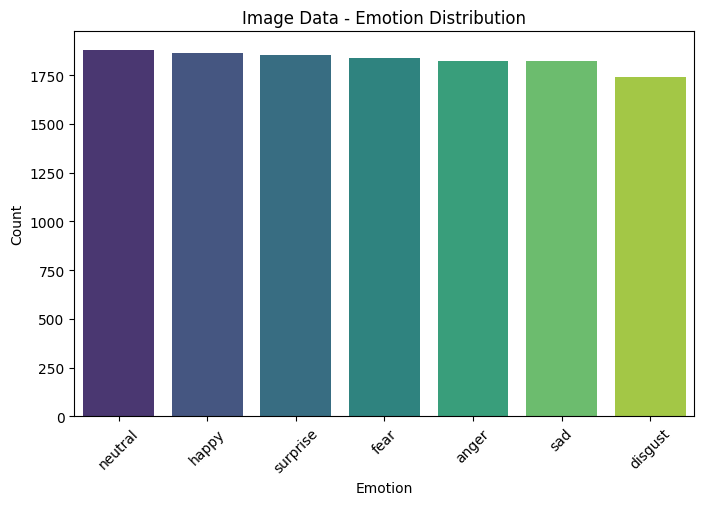

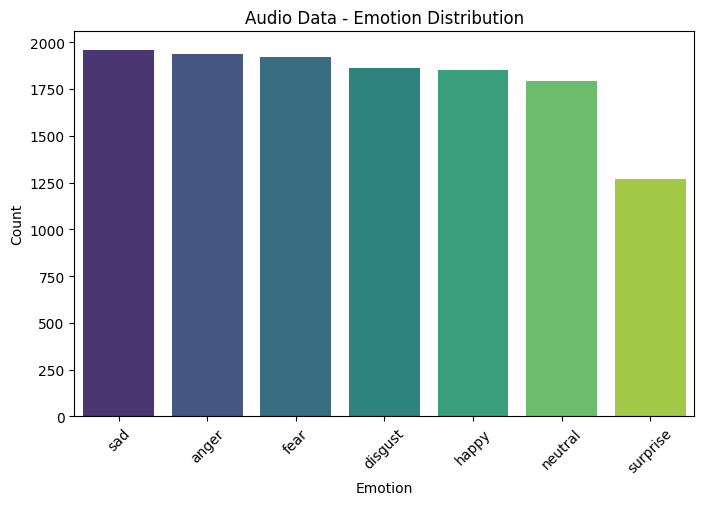

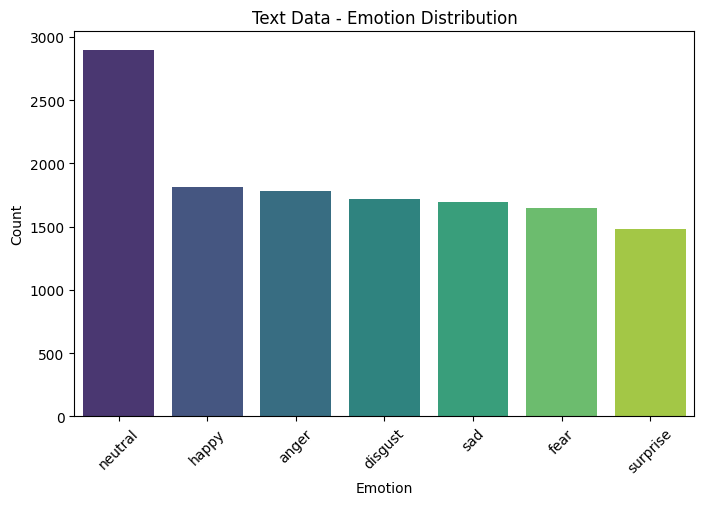

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Function to count files in each emotion folder
def count_emotion_samples(base_path):
    emotion_counts = {}
    for emotion in os.listdir(base_path):  # Iterate through emotion folders
        emotion_folder = os.path.join(base_path, emotion)
        if os.path.isdir(emotion_folder):  # Ensure it's a folder
            emotion_counts[emotion] = len(os.listdir(emotion_folder))
    return emotion_counts

# Get counts
image_counts = count_emotion_samples(IMAGES_PATH)
audio_counts = count_emotion_samples(AUDIOS_PATH)
text_counts = count_emotion_samples(TEXT_PATH)

# Convert to DataFrame for plotting
import pandas as pd
image_df = pd.DataFrame(list(image_counts.items()), columns=["Emotion", "Count"])
audio_df = pd.DataFrame(list(audio_counts.items()), columns=["Emotion", "Count"])
text_df = pd.DataFrame(list(text_counts.items()), columns=["Emotion", "Count"])

# Function to plot emotion distribution
def plot_emotion_distribution(df, title):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x="Emotion", y="Count", palette="viridis", order=df.sort_values("Count", ascending=False)["Emotion"])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plot distributions
plot_emotion_distribution(image_df, "Image Data - Emotion Distribution")
plot_emotion_distribution(audio_df, "Audio Data - Emotion Distribution")
plot_emotion_distribution(text_df, "Text Data - Emotion Distribution")


# *> ***Main Training and Evaluation****

In [1]:
import pandas as pd

Zipping completed!


In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
from PIL import Image
from transformers import BertTokenizer, BertModel
import string  # Add this line with other imports
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
import warnings
warnings.filterwarnings("ignore")

IMAGES_PATH = "/kaggle/input/images-data"
AUDIOS_PATH = "/kaggle/input/augmented-data/Aug_Audio/Aug_Audio"
TEXT_PATH = "/kaggle/input/augmented-data/Augmented_data/Augmented_data"



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load Pretrained Wav2Vec2 Model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device)

print(device)
# Data Preprocessing Functions
def load_modality_data(path, modality):
    data = {}
    for emotion in os.listdir(path):
        emotion_path = os.path.join(path, emotion)
        if os.path.isdir(emotion_path):
            files = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path)]
            if files:
                data[emotion] = files
    print(f"Loaded {len(data)} emotions for {modality}")
    return data

# Load and split data
images_data = load_modality_data(IMAGES_PATH, "images")
audios_data = load_modality_data(AUDIOS_PATH, "audio")
texts_data = load_modality_data(TEXT_PATH, "text")

all_labels = sorted(set(images_data.keys()) | set(audios_data.keys()) | set(texts_data.keys()))
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}

# Split each modality into train/test
def split_modality(data):
    train, test = {}, {}
    for label, samples in data.items():
        train_samples, test_samples = train_test_split(samples, test_size=0.2, random_state=42)
        train[label] = train_samples
        test[label] = test_samples
    return train, test

image_train, image_test = split_modality(images_data)
audio_train, audio_test = split_modality(audios_data)
text_train, text_test = split_modality(texts_data)

def process_image(image_path):
    # Image Augmentations
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Add this
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Add this
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def process_audio(audio_path, target_length=42240):  # 3 seconds at 16 kHz
    y, sr = librosa.load(audio_path, sr=16000)
    y = librosa.util.normalize(y)  # Normalize to [-1, 1]
    
    # Pad or truncate to target_length
    if len(y) > target_length:
        y = y[:target_length]  # Truncate
    else:
        y = np.pad(y, (0, max(0, target_length - len(y))), mode='constant')  # Pad
    
    return torch.from_numpy(y.astype(np.float32))  # Shape: (sequence_length,)

def process_text(text_path):
    with open(text_path, 'r') as f:
        text = f.read().lower().translate(str.maketrans('', '', string.punctuation))
    inputs = tokenizer(text, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
    return inputs['input_ids'].squeeze(0)

# Dataset Class
class MultimodalDataset(Dataset):
    def __init__(self, image_data, audio_data, text_data, downsample=True):
        self.image_data = image_data
        self.audio_data = audio_data
        self.text_data = text_data
        self.labels = all_labels
        self.downsample = downsample  # Control whether to downsample
        
        # Precompute balanced samples
        self.samples = []
        for emotion in self.labels:
            # Calculate minimum samples across all modalities for this emotion
            img_count = len(image_data.get(emotion, []))
            aud_count = len(audio_data.get(emotion, []))
            txt_count = len(text_data.get(emotion, []))
            min_samples = min(img_count, aud_count, txt_count) if self.downsample else max(img_count, aud_count, txt_count)
            
            if min_samples == 0:
                continue  # Skip emotions with no samples in any modality
            
            # Print the number of samples for each modality
            print(f"Emotion: {emotion}")
            print(f"  Image Samples: {img_count} -> Using: {min_samples}")
            print(f"  Audio Samples: {aud_count} -> Using: {min_samples}")
            print(f"  Text Samples: {txt_count} -> Using: {min_samples}")
            print("-" * 40)
            
            # Get samples for each modality
            img_samples = self._safe_sample(image_data.get(emotion, []), min_samples)
            aud_samples = self._safe_sample(audio_data.get(emotion, []), min_samples)
            txt_samples = self._safe_sample(text_data.get(emotion, []), min_samples)
            
            # Create triplets (image, audio, text)
            for i in range(min_samples):
                self.samples.append((
                    img_samples[i % len(img_samples)],
                    aud_samples[i % len(aud_samples)],
                    txt_samples[i % len(txt_samples)],
                    emotion
                ))
        random.shuffle(self.samples)
        
    def _safe_sample(self, samples, min_samples):
        """Ensure we have at least `min_samples` (with repetition if needed)."""
        if len(samples) >= min_samples:
            return random.sample(samples, min_samples)
        else:
            return (samples * (min_samples // len(samples) + 1))[:min_samples]
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, aud_path, txt_path, emotion = self.samples[idx]
        img = process_image(img_path)
        audio = process_audio(aud_path, target_length=42240)
        text = process_text(txt_path)
        label = label_to_idx[emotion]  # emotion is already a string
        
        return {
            'image': img,
            'audio': audio,
            'text': text,
            'label': torch.tensor(label)  # label is already an integer
        }

# Create datasets and loaders
train_dataset = MultimodalDataset(image_train, audio_train, text_train, downsample=True)  # Downsample for training
test_dataset = MultimodalDataset(image_test, audio_test, text_test, downsample=False)  # No downsampling for testing

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(test_dataset)}")

# Model Architecture
class ImageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet50(pretrained=True)
        # Freeze initial layers
        for param in self.cnn.parameters():
            param.requires_grad = False
        self.cnn.fc = nn.Sequential(
            nn.Linear(self.cnn.fc.in_features, 512),
            nn.LayerNorm(512)
        )
    def forward(self, x):
        return self.cnn(x)

from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor

class AudioModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.fc = nn.Linear(768, 512)
        self.norm = nn.LayerNorm(512)
    def forward(self, x):
        # Ensure input is 1D (batch_size, sequence_length)
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        # Process through Wav2Vec2
        outputs = self.wav2vec(x)
        x = outputs.last_hidden_state.mean(dim=1)  # Average over time dimension
        x = self.fc(x)
        return self.norm(x)

class TextModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, 512)
        self.norm = nn.LayerNorm(512)

    def forward(self, x):
        outputs = self.bert(input_ids=x, attention_mask=(x > 0).float())
        cls_token_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
        return self.norm(self.fc(cls_token_embedding))  # Use CLS instead of mean pooling


class AttentionFusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(512*3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3),
            nn.Softmax(dim=1)
        )
        # Initialize weights to be more balanced
        self.attention[3].weight.data.normal_(mean=0.0, std=0.01)
    
    def forward(self, features):
        combined = torch.cat(features, dim=1)
        weights = self.attention(combined)
        return sum(weights[:, i].unsqueeze(1) * features[i] for i in range(3)), weights
        
class MultimodalModel(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.image_model = ImageModel()
        self.audio_model = AudioModel()
        self.text_model = TextModel()
        self.fusion = AttentionFusion()
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, img, audio, text):
        img_feat = self.image_model(img)
        audio_feat = self.audio_model(audio)
        text_feat = self.text_model(text)
        fused,weights = self.fusion([img_feat, audio_feat, text_feat])
        return self.classifier(fused),weights

# Training Setup
model = MultimodalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss()

# Training Loop without Early Stopping
best_val_loss = float('inf')  # Still track best validation loss for saving the best model

for epoch in range(5):  # Train for a fixed number of epochs
    model.train()
    train_loss = 0.0
    progress = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]')
    for batch in progress:
        optimizer.zero_grad()
        outputs, weights = model(batch['image'].to(device), 
                                batch['audio'].to(device), 
                                batch['text'].to(device))
        loss = criterion(outputs, batch['label'].to(device))
        target_weights = torch.tensor([0.4, 0.3, 0.3], device=device)  # Adjust as needed
        weight_penalty = torch.nn.functional.mse_loss(weights.mean(dim=0), target_weights)
        loss += 0.5 * weight_penalty  # Adjust lambda as needed
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress.set_postfix(loss=loss.item())
    
    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        progress = tqdm(test_loader, desc=f'Epoch {epoch+1} [Val]')
        for batch in progress:
            outputs, weights = model(batch['image'].to(device), 
                                    batch['audio'].to(device), 
                                    batch['text'].to(device))
            loss = criterion(outputs, batch['label'].to(device))
            target_weights = torch.tensor([0.4, 0.3, 0.3], device=device)  # Adjust as needed
            weight_penalty = torch.nn.functional.mse_loss(weights.mean(dim=0), target_weights)
            loss += 0.5 * weight_penalty  # Adjust lambda as needed
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['label'].numpy())
    
    # Normalize validation loss
    val_loss /= len(test_loader)
    
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")
    
    # Step the scheduler
    scheduler.step()
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'multi_model.pth')

# Evaluation
model.load_state_dict(torch.load('multi_model.pth'))
model.eval()
all_preds = []
all_labels = []
all_weights = []
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        outputs, weights = model(batch['image'].to(device), 
                                batch['audio'].to(device), 
                                batch['text'].to(device))
        loss = criterion(outputs, batch['label'].to(device))
        test_loss += loss.item()
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(batch['label'].numpy())
        all_weights.append(weights.cpu().numpy())

# Normalize test loss
test_loss /= len(test_loader)

avg_weights = np.mean(np.concatenate(all_weights, axis=0), axis=0)
# Print weightage assigned to each modality
print(f"Average Weightage - Image: {avg_weights[0]:.4f}, Audio: {avg_weights[1]:.4f}, Text: {avg_weights[2]:.4f}")
print()
print("Classification Report:")
print(classification_report(all_labels, all_preds))
print()
print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("Weighted F1:", f1_score(all_labels, all_preds, average='weighted'))
print(f"Test Loss: {test_loss:.4f}")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

cuda
Loaded 7 emotions for images
Loaded 7 emotions for audio
Loaded 7 emotions for text


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Emotion: anger
  Image Samples: 1457 -> Using: 1428
  Audio Samples: 1548 -> Using: 1428
  Text Samples: 1428 -> Using: 1428
----------------------------------------
Emotion: disgust
  Image Samples: 1392 -> Using: 1377
  Audio Samples: 1490 -> Using: 1377
  Text Samples: 1377 -> Using: 1377
----------------------------------------
Emotion: fear
  Image Samples: 1471 -> Using: 1318
  Audio Samples: 1536 -> Using: 1318
  Text Samples: 1318 -> Using: 1318
----------------------------------------
Emotion: happy
  Image Samples: 1489 -> Using: 1450
  Audio Samples: 1482 -> Using: 1450
  Text Samples: 1450 -> Using: 1450
----------------------------------------
Emotion: neutral
  Image Samples: 1504 -> Using: 1436
  Audio Samples: 1436 -> Using: 1436
  Text Samples: 2319 -> Using: 1436
----------------------------------------
Emotion: sad
  Image Samples: 1456 -> Using: 1356
  Audio Samples: 1568 -> Using: 1356
  Text Samples: 1356 -> Using: 1356
----------------------------------------
Emo

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s] 


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 [Val]: 100%|██████████| 90/90 [01:28<00:00,  1.01it/s]


Epoch 1 | Train Loss: 0.7150 | Val Loss: 0.5346


Epoch 2 [Val]: 100%|██████████| 90/90 [01:17<00:00,  1.16it/s]


Epoch 2 | Train Loss: 0.2929 | Val Loss: 0.2807


Epoch 3 [Val]: 100%|██████████| 90/90 [01:17<00:00,  1.16it/s]


Epoch 3 | Train Loss: 0.1575 | Val Loss: 0.2736


Epoch 4 [Val]: 100%|██████████| 90/90 [01:16<00:00,  1.17it/s]


Epoch 4 | Train Loss: 0.0530 | Val Loss: 0.2563


Epoch 5 [Val]: 100%|██████████| 90/90 [01:16<00:00,  1.17it/s]


Epoch 5 | Train Loss: 0.0181 | Val Loss: 0.2363
Average Weightage - Image: 0.3373, Audio: 0.3535, Text: 0.3092

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       388
           1       0.95      0.92      0.93       373
           2       0.94      0.90      0.92       385
           3       0.91      0.86      0.89       373
           4       0.90      0.95      0.93       580
           5       0.87      0.90      0.89       392
           6       1.00      0.99      1.00       371

    accuracy                           0.92      2862
   macro avg       0.93      0.92      0.92      2862
weighted avg       0.92      0.92      0.92      2862


Macro F1: 0.9231667939311806
Weighted F1: 0.9230751035541572
Test Loss: 0.2291


# Download the model

In [4]:
import torch

# Prepare example inputs with appropriate shapes
example_image = torch.randn(1, 3, 224, 224, device=device)
example_audio = torch.randn(1, 42240, device=device)
# For text, create a dummy tensor (using BERT's typical vocab range; adjust as needed)
example_text = torch.randint(0, 30522, (1, 128), device=device)

traced_model = torch.jit.trace(model, (example_image, example_audio, example_text))
torch.jit.save(traced_model, "expression_modal_traced.pt")


Download your files below:


/kaggle/working/images_data.zip

/kaggle/working/aug_audio.zip

/kaggle/working/augmented_text.zip

# Weightage

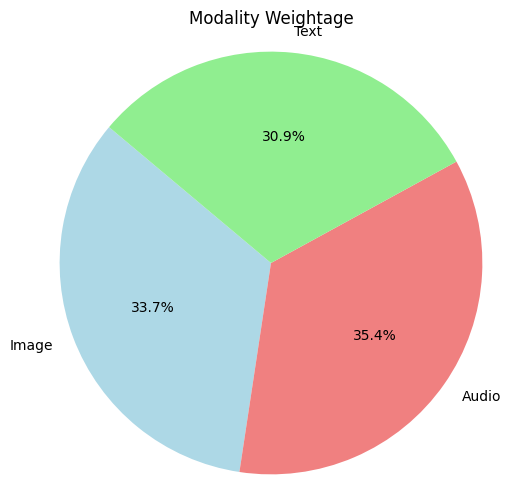

In [11]:
# Plotting the Modality Weightage as a Pie Chart
import matplotlib.pyplot as plt
def plot_weightage(avg_weights):
    """
    Plots a pie chart of modality contributions.
    Expects avg_weights to be a numpy array of shape (3,) with order: [Image, Audio, Text]
    """
    labels = ['Image', 'Audio', 'Text']
    sizes = avg_weights.tolist()
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title("Modality Weightage")
    plt.show()

# Call the plot function with your model's average weights
plot_weightage(avg_weights)

# Confusion matrix

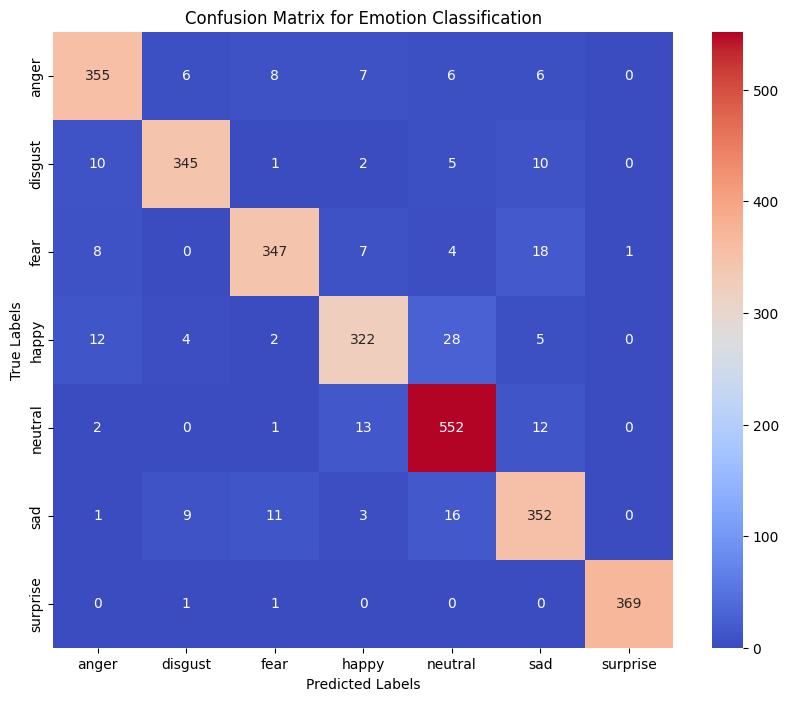

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the original labels
emotion_labels = sorted(label_to_idx.keys())  # Extract labels from dictionary

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=emotion_labels, yticklabels=emotion_labels)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Emotion Classification")
plt.savefig("multi_modal_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
# 1) Zip the file (optional but often helps with large file downloads)
!zip multi_model.zip multi_model.pth

# 2) Create a download link in the output
from IPython.display import FileLink
FileLink('multi_model.zip')


  adding: multi_model.pth (deflated 7%)


/kaggle/working/multi_model.zip

# Prediction on some text

In [16]:
class MultimodalInference:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        
        # 1) Instantiate the same model architecture you trained
        self.model = MultimodalModel(num_classes=7).to(device)
        
        # 2) Load the saved state dict (weights)
        state_dict = torch.load(model_path, map_location=device)
        self.model.load_state_dict(state_dict)
        
        # 3) Now call eval on the actual model
        self.model.eval()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.label_names = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    def process_image(self, image_path):
        img = Image.open(image_path).convert('RGB')
        return self.image_transform(img).unsqueeze(0).to(self.device)

    def process_audio(self, audio_path):
        # Load raw waveform
        y, sr = librosa.load(audio_path, sr=16000)
        
        # Ensure the waveform is 1D and normalized
        y = librosa.util.normalize(y)
        
        # Pad or truncate to a fixed length (e.g., 3 seconds at 16 kHz = 48000 samples)
        target_length = 48000  # Adjust based on your dataset
        if len(y) > target_length:
            y = y[:target_length]  # Truncate
        else:
            y = np.pad(y, (0, max(0, target_length - len(y))), mode='constant')  # Pad
        
        # Convert to tensor and add batch dimension
        return torch.FloatTensor(y).unsqueeze(0).to(self.device)

    def process_text(self, text_path):
        with open(text_path, 'r') as f:
            text = f.read().lower().translate(str.maketrans('', '', string.punctuation))
        inputs = self.tokenizer(text, padding='max_length', max_length=128, 
                              truncation=True, return_tensors='pt')
        return inputs['input_ids'].squeeze(0).unsqueeze(0).to(self.device)

    def predict(self, image_path=None, audio_path=None, text_path=None):
        # Initialize empty tensors for missing modalities
        img = torch.zeros(1, 3, 224, 224).to(self.device) if not image_path else self.process_image(image_path)
        audio = torch.zeros(1, 48000).to(self.device) if not audio_path else self.process_audio(audio_path)
        text = torch.zeros(1, 128).long().to(self.device) if not text_path else self.process_text(text_path)
    
        with torch.no_grad():
            features = [
                self.model.image_model(img),
                self.model.audio_model(audio),
                self.model.text_model(text)
            ]
    
            # Get raw attention weights from the fusion layer
            combined = torch.cat(features, dim=1)
            raw_weights = self.model.fusion.attention(combined)
    
            # Create a presence mask indicating which modalities are provided
            present = [1 if path else 0 for path in [image_path, audio_path, text_path]]
            mask = torch.tensor(present, dtype=torch.float32).to(self.device)
    
            # Adjust the weights based on the presence mask
            adjusted_weights = raw_weights * mask
            adjusted_weights = adjusted_weights / adjusted_weights.sum(dim=1, keepdim=True)
    
            # Map the modality names to the respective weights
            modality_names = ['image', 'audio', 'text']
            modality_weights = {modality_names[i]: adjusted_weights[0, i].item() for i in range(len(modality_names))}
    
            # Fuse features with the adjusted weights
            fused = sum(adjusted_weights[0, i] * features[i] for i in range(3))
            output = self.model.classifier(fused)
    
        pred = torch.softmax(output, dim=1)
        return {
            'label': self.label_names[torch.argmax(pred).item()],
            'confidence': torch.max(pred).item(),
            'weights': modality_weights,  # Dictionary mapping modality names to weights
            'present_modalities': {'image': bool(image_path), 'audio': bool(audio_path), 'text': bool(text_path)}
        }

# Command-line evaluation example
inferencer = MultimodalInference('/kaggle/working/multi_model.pth')

result = inferencer.predict(
    image_path='/kaggle/input/images-data/anger/10_image0000593.jpg',
    audio_path="/kaggle/input/audio-text-data/Emotions_Audio/Emotions_Audio/disgust/03-01-07-01-01-01-22.wav",
    text_path="/kaggle/input/audio-text-data/Text_data/Text_data/neutral/train_1725.txt"
)

print("Modality Weights:", result['weights'])
print(f"Predicted Emotion: {result['label']}")

# Determine the dominant modality by selecting the key with the highest weight
dominant_modality = max(result['weights'], key=result['weights'].get)
print(f"Prediction was primarily influenced by: {dominant_modality}")

Modality Weights: {'image': 0.325662225484848, 'audio': 0.48307889699935913, 'text': 0.19125892221927643}
Predicted Emotion: disgust
Prediction was primarily influenced by: audio
